#  Maximum Likelihood Estimation with Bivariate Gaussians
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Zeyuzhao/Notebooks/blob/master/mle_gaussian.ipynb)


## Data Generation

We generate a dataset by sampling from a bivariate gaussian distribution. 
We use two parameters to determine this data distribution: `mean` and `cov`, which is the covariance of the distribution. In this implementation, the cholesky decomposition `L` of `cov` is used instead, to ensure that the `cov` matrix is valid (positive semi-definite).

In [0]:
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
import torch.distributions.multivariate_normal as normal
from scipy.stats import multivariate_normal
%matplotlib inline

In [3]:
# We offset the distribution by the mean
mean = [0.5, 1.5]

# This is cholsky decomposition of the covariance matrix
# Ensures that the covariance matrix is positive semi-definite
L = np.array([[1, -1.5], 
              [0, 1]]) / 2
cov = L @ L.T
cov

array([[ 0.8125, -0.375 ],
       [-0.375 ,  0.25  ]])

In [0]:
# Generates the dataset from mean and cov
rng = np.random.default_rng(seed=41)
(x, y) = rng.multivariate_normal(mean, cov, 500).T

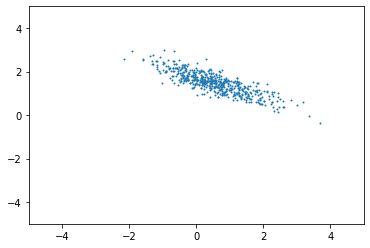

In [5]:
fig = plt.figure()

ax = fig.add_subplot(1,1,1)

plt.xlim(-5, 5)
plt.ylim(-5, 5)

ax.scatter(x, y, s=1)
plt.show()

In [6]:
# Compute mean and covariance from the dataset

combinedxy = np.stack([x, y], axis = 1)

print("Covariance of dataset: \n", np.cov(combinedxy.transpose()))
print("Mean of dataset: \n", np.mean(combinedxy, axis=0))


Covariance of dataset: 
 [[ 0.85337796 -0.39707956]
 [-0.39707956  0.26325601]]
Mean of dataset: 
 [0.52975302 1.48668041]


## MLE with gradient descent

This section is the crux our notebook: we would like to train our bivariate gaussian model using **gradient ascent** on the following Maximum Likelihood Estimator:
$$\DeclareMathOperator*{\argmax}{arg\,max}$$
$$\argmax_{\theta} \sum_{x \in D}^{}\frac{1}{|D|}\log(p_{\theta}(x))$$

In this implementation, however, we use the negative of our objective function, and we call this `J`, our loss function. We use this formulation so that you can use any other off-the-shelf **gradient descent** algorithm, such as ADAM. 

In [0]:
# Import NumPy arrays to Tensors
X = torch.from_numpy(x).float()
Y = torch.from_numpy(y).float()

# The parameters of our model
mean = torch.zeros((2), requires_grad=True)
cov = torch.eye(2, requires_grad=True)

learning_rate = 8e-3

m = normal.MultivariateNormal(mean, cov)

# Track parameters and losses over training
hist_mean = []
hist_cov = []
hist_loss = []

In [0]:
dataset = torch.stack([X, Y], dim=1)
n = len(dataset)
iterations = 500

for t in range(iterations):
    # Foward Propagation
    m = normal.MultivariateNormal(mean, cov)
    J = -1/n * m.log_prob(dataset).sum()
    
    # Backpropagate Losses
    J.backward()
    
    # Update parameters
    with torch.no_grad():
        mean -= learning_rate * mean.grad
        cov -= learning_rate * cov.grad

        mean.grad.zero_()
        cov.grad.zero_()

    if t % 100 == 99:
        print("Iteration: {0}\tLoss: {1}".format(t, J))
        print(mean_val)
        
    if t % 10 == 9:
        # Detach and clone values to the history tracking arrays
        mean_val = mean.cpu().detach().clone().numpy()
        cov_val = cov.cpu().detach().clone().numpy()
        loss_val = J.cpu().detach().clone().numpy()
        hist_mean.append(mean_val)
        hist_cov.append(cov_val)
        hist_loss.append(loss_val)

Iteration: 99	Loss: 1.484229564666748
[0.5297588 1.4866772]
Iteration: 199	Loss: 1.4842300415039062
[0.5297588 1.4866772]
Iteration: 299	Loss: 1.4842296838760376
[0.5297588 1.4866772]
Iteration: 399	Loss: 1.484229564666748
[0.5297588 1.4866772]
Iteration: 499	Loss: 1.4842296838760376
[0.5297588 1.4866772]


## Visualization

### Final Gaussian Model Plot

In [0]:
# Create mesh for our density plots
meshX, meshY = np.mgrid[-4:4:.01, -4:4:.01]
pos = np.dstack((meshX, meshY))

# Evaluate densities at mesh positions
density = multivariate_normal(hist_mean[-1], hist_cov[-1])
meshZ = density.pdf(pos)

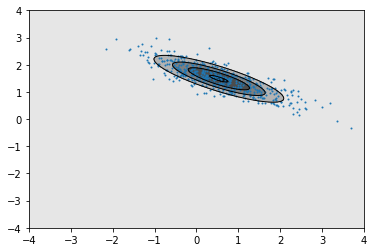

In [0]:
fig = plt.figure()

ax = fig.add_subplot(1,1,1)
plt.xlim(-4, 4)
plt.ylim(-4, 4)

ax.contour(meshX, meshY, meshZ, levels=4, linewidths=1, colors='k')
ax.contourf(meshX, meshY, meshZ, levels=4, cmap="binary")

ax.scatter(x, y, s=1)
plt.show()

### Model Animation of Training

We animate the evolution of our parameters through the training process. The history of our parameters and losses are stored in `hist_mean`, `hist_cov`, and `hist_loss` respectively.



In [0]:
%%capture
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from matplotlib import animation, rc
from IPython.display import HTML

fig = plt.figure()
ax = fig.add_subplot(1,1,1)
plt.xlim(-4, 4)
plt.ylim(-4, 4)

# Create mesh for plotting
meshX, meshY = np.mgrid[-4:4:.01, -4:4:.01]
pos = np.dstack((meshX, meshY))

# Compute initial densities
density = multivariate_normal(hist_mean[0], hist_cov[0])
meshZ = density.pdf(pos)

# Initialize contour and filled contour plots
contours = [0] * 2
contours[0] = ax.contourf(meshX, meshY, meshZ, levels=4, cmap="binary");
contours[1] = ax.contour(meshX, meshY, meshZ, levels=4, linewidths=1, colors='k');

# Initialize loss label box
props = dict(boxstyle='round', facecolor='whitesmoke')
losslabel = ax.text(0.15, 0.1, "", transform=ax.transAxes, ha="center", bbox=props)

def update(i):
    # Clear contour plot cache
    for tp in contours[0].collections:
        tp.remove()
    for tp in contours[1].collections:
        tp.remove()
    
    # Update contour plots with historic training parameters
    density = multivariate_normal(hist_mean[i], hist_cov[i])
    meshZ = density.pdf(pos)
    contours[0] = ax.contourf(meshX, meshY, meshZ, levels=6, 
                              cmap="binary", vmin=0, vmax=0.65)
    contours[1] = ax.contour(meshX, meshY, meshZ, levels=6, 
                             linewidths=1, colors='k')
    # Display historic training loss
    losslabel.set_text("Loss: {0:.3f}".format(hist_loss[i]))
    # Overlay data scatter plot
    ax.scatter(x, y, s=2, color="c", alpha=0.5)
    return contours[0].collections + contours[1].collections

anim = matplotlib.animation.FuncAnimation(fig, update, frames=len(hist_mean)* 3 // 4, 
                                         interval=50, blit=True, repeat=True)

In [0]:
HTML(anim.to_jshtml())

### KL Divergence and Maximum Likelihood Estimation
We would like to match the parametric distribution $p_{\theta}$ with the empirical distribution $p_{data}$.

To do so, we will minimize the KL divergence of the two distributions with respect to $\theta$:
$
\DeclareMathOperator{\E}{\mathbb{E}}
\DeclareMathOperator*{\argmax}{arg\,max}
\DeclareMathOperator*{\argmin}{arg\,min}
$
\begin{equation}
\begin{split}
\theta_{ML} &= \argmin_{\theta} D_{KL}(p_{data}\parallel p_{\theta}) \\
            &= \argmin_{\theta} \E_{x \sim p_{data}}[\log p_{data}(x) - \log p_{\theta}(x)] \\
            &= \argmin_{\theta} -\E_{x \sim p_{data}}[\log p_{\theta}(x)] \\
            &= \argmax_{\theta} \E_{x \sim p_{data}}[\log p_{\theta}(x)]
\end{split}
\end{equation}

The last equation is the maximum likelihood estimator for the parameter $\theta_{ML}$. We can express this empirically by averaging samples from the dataset $D$.
$$
\argmax_{\theta} \sum_{x \in D}^{}\frac{1}{|D|}\log(p_{\theta}(x))
$$

We ran a gradient descent algorithm to find the optimal parameters $\theta_{ML}$.